In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
from atl_module.io import atl03_netcdf_loading
from atl_module.geospatial_utils.geospatial_functions import add_track_dist_meters
import pandas as pd
import geopandas as gpd
from netCDF4 import Dataset
import contextily as cx

In [10]:
# netcdf_path = (
#     "../data/test_sites/oahu7/ATL03/processed_ATL03_20190908101513_11050401_005_01.nc"
# )
netcdf_path = "../data/test_sites/florida_keys/ATL03/processed_ATL03_20190307135537_10560201_005_01.nc"

beam = "gt3l"
ds = Dataset(netcdf_path)
ref_ph_lats = ds.groups[beam].groups["geolocation"].variables["reference_photon_lat"][:]
ref_ph_lons = ds.groups[beam].groups["geolocation"].variables["reference_photon_lon"][:]

In [11]:
allpts = atl03_netcdf_loading.load_beam_array_ncds(netcdf_path, beam)

In [12]:
len(allpts)

72040

In [13]:
df_dist = add_track_dist_meters(allpts)

# countdf = df_dist.set_index("delta_time").dist_or.rolling(window="3ms").count()
# print(countdf)
# countdf.plot.hist()

In [7]:
all_ph = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(allpts["X"], allpts["Y"]), crs="EPSG:4326"
)
all_ph = all_ph.to_crs(all_ph.estimate_utm_crs())
ref_ph = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(ref_ph_lons, ref_ph_lats), crs="EPSG:4326"
).to_crs(all_ph.estimate_utm_crs())
all_ph.to_file("../data/derived/example_photons")
ref_ph.to_file("../data/derived/reference_photons")

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [14]:
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle

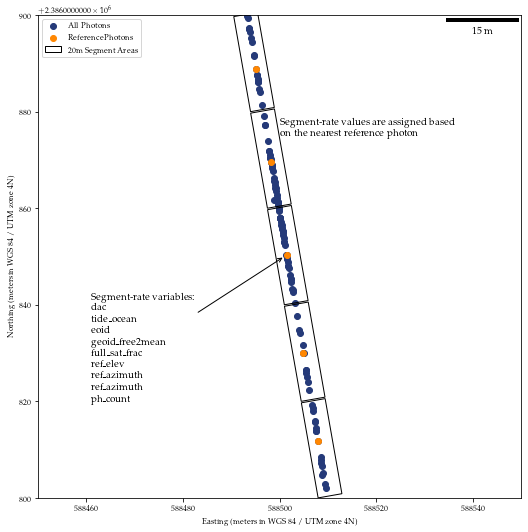

In [16]:
ax = all_ph.plot(figsize=(7.5, 7.5))
ref_ph.plot(ax=ax)
ax.set_ylim((2386800, 2386900))
ax.set_xlim((588450, 588550))
# , -158.1449944,


# TODO add a scale bar
cx.add_basemap(ax=ax, source=cx.providers.Stamen.Terrain, crs=all_ph.crs)
ax.add_artist(ScaleBar(1))
ax.set_xlabel(f"Easting (meters in {all_ph.crs.name})")
ax.set_ylabel(f"Northing (meters in {all_ph.crs.name})")

y = (2386800 + 2386900) / 2 - 10
x = (588450 + 588550) / 2 + 1
mrguy = Rectangle(
    (x, y),
    5,
    20,
    edgecolor="black",
    fill=False,
    angle=10,
    label="Reference photon area",
)
mrguy2 = Rectangle((x - 3.5, y + 20), 5, 20, edgecolor="black", fill=False, angle=10)
mrguy3 = Rectangle((x + 3.5, y - 20), 5, 20, edgecolor="black", fill=False, angle=10)
mrguy4 = Rectangle(
    (x + 3.5 * 2, y - 20 * 2), 5, 20, edgecolor="black", fill=False, angle=10
)
mrguy5 = Rectangle(
    (x - 3.5 * 2, y + 20 * 2), 5, 20, edgecolor="black", fill=False, angle=10
)

ax.add_patch(mrguy)
ax.add_patch(mrguy2)
ax.add_patch(mrguy3)
ax.add_patch(mrguy4)
ax.add_patch(mrguy5)
ax.annotate(
    text="Segment-rate values are assigned based \n on the nearest reference photon",
    xy=(588500, 2386875),
)
ax.annotate(
    "Segment-rate variables: \n dac \n tide_ocean \n eoid \n geoid_free2mean \n full_sat_frac \n  ref_elev \n ref_azimuth \n ref_azimuth \n ph_count",
    xy=(x, y + 10),
    xytext=(x - 40, y - 20),
    arrowprops=dict(arrowstyle="->"),
)
ax.legend(["All Photons", "Reference Photons", "20m Segment Areas"], loc="upper left")
ax.get_figure().savefig(
    "../document/figures/reference_photon_plot.pdf", dpi=500, bbox_inches="tight"
)